# **Stacked LTSM Model for Stock Price Prediction**


In [46]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import pandas_datareader as reader
import matplotlib.pyplot as plt
import math as calculate
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import tensorflow

# Using the Tiingo API to access daily financial data
stock = input("Enter Stock Ticker: ")
dataFrame = reader.get_data_tiingo(stock, api_key= '97edc0f44b60fb2b588a96724400828e8daeed79')

# Exporting data to CSV File.
dataFrame.to_csv('data.csv')

Enter Stock Ticker: AAPL


<ipython-input-46-e7b0af6bfe10>:16: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  dataFrame = reader.get_data_tiingo(stock, api_key= '97edc0f44b60fb2b588a96724400828e8daeed79')


In [47]:
# Selecting only the close data for this prediction:
dataFrame = pd.read_csv('data.csv')
dataFrame = dataFrame.loc[dataFrame["date"] >= '2020-09-12']
dataFrame.index = np.arange(0, len(dataFrame))
dataFrame.tail(5)

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
685,AAPL,2023-06-05 00:00:00+00:00,179.58,184.951,178.035,182.630,121946497,179.58,184.951,178.035,182.630,121946497,0.0,1.0
686,AAPL,2023-06-06 00:00:00+00:00,179.21,180.120,177.430,179.965,64848374,179.21,180.120,177.430,179.965,64848374,0.0,1.0
687,AAPL,2023-06-07 00:00:00+00:00,177.82,181.210,177.320,178.440,61944615,177.82,181.210,177.320,178.440,61944615,0.0,1.0
688,AAPL,2023-06-08 00:00:00+00:00,180.57,180.840,177.460,177.895,50214881,180.57,180.840,177.460,177.895,50214881,0.0,1.0
689,AAPL,2023-06-09 00:00:00+00:00,180.96,182.230,180.630,181.500,48899973,180.96,182.230,180.630,181.500,48899973,0.0,1.0


Text(0, 0.5, 'AAPL Stock Price')

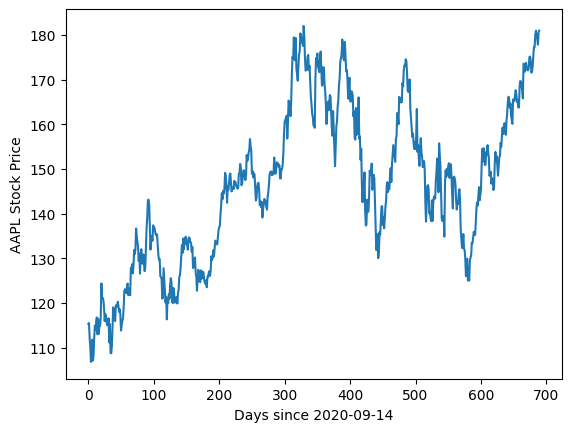

In [48]:
# Plotting the close prices from 
dataFrame = dataFrame["close"]
plt.plot(dataFrame)
plt.xlabel("Days since 2020-09-14")
plt.ylabel(stock + " Stock Price")

In [49]:
dataFrame

0      115.355
1      115.540
2      112.130
3      110.340
4      106.840
        ...   
685    179.580
686    179.210
687    177.820
688    180.570
689    180.960
Name: close, Length: 690, dtype: float64

In [50]:
# As LTSM Models are sensititve to the scale of the data, we will transform 
# the data using the MinMax Scaler.
scaler = MinMaxScaler(feature_range = (0, 1))
dataFrame = scaler.fit_transform(np.array(dataFrame).reshape(-1, 1))

# dataFrame is now converted to an array of values from 0 to 1 for the LTSM Model.
# Now we will preprocess our data and split into Training and Testing Data
size = len(dataFrame)
size_training = int(size * .75)               # 75% of the data
size_validation = int(size - size_training)   # 25% of the data
print("Training Size for this model is", size_training, "datapoints.")
print("Validation Size for this model is", size_validation, "datapoints.")

Training Size for this model is 517 datapoints.
Validation Size for this model is 173 datapoints.


In [51]:
training_data = dataFrame[0:size_training, :]
validation_data = dataFrame[len(training_data):len(dataFrame), :]
len(training_data), len(validation_data)

(517, 173)

In [52]:
# Now we will convert the array of values into a matrix using a function.
def create_dataset(dataset, time_step = 1):
  dataX = []
  dataY = []
  for i in range(len(dataset)-1-time_step):
    a = dataset[i:(i + time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])
  return np.array(dataX), np.array(dataY)

In [53]:
time_step = 100
x_train, y_train = create_dataset(training_data, time_step)
x_validate, y_validate = create_dataset(validation_data, time_step)
x_train.shape, y_train.shape, x_validate.shape, y_validate.shape

((416, 100), (416,), (72, 100), (72,))

In [54]:
# Now we will reshape to transform the data into a 3 dimensional matrix,
# in order to create the stacked LSTM Model.
# Format is [data, timestep, feature]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_validate = x_validate.reshape(x_validate.shape[0], x_validate.shape[1], 1)

In [55]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences = True, input_shape = (100, 1)))
lstm_model.add(LSTM(50, return_sequences = True))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))
lstm_model.compile(loss = "mean_squared_error", optimizer = "adam")
model_summary = lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [56]:
lstm_model.fit(x_train, y_train, validation_data = (x_validate, y_validate), epochs = 100, batch_size = 64, verbose=1)

Epoch 1/100
7/7 [==============================] - 10s 396ms/step - loss: 0.1644 - val_loss: 0.0300
Epoch 2/100
7/7 [==============================] - 1s 193ms/step - loss: 0.0329 - val_loss: 0.0660
Epoch 3/100
7/7 [==============================] - 2s 247ms/step - loss: 0.0262 - val_loss: 0.0094
Epoch 4/100
7/7 [==============================] - 2s 330ms/step - loss: 0.0163 - val_loss: 0.0053
Epoch 5/100
7/7 [==============================] - 1s 198ms/step - loss: 0.0123 - val_loss: 0.0242
Epoch 6/100
7/7 [==============================] - 1s 194ms/step - loss: 0.0126 - val_loss: 0.0062
Epoch 7/100
7/7 [==============================] - 1s 197ms/step - loss: 0.0114 - val_loss: 0.0093
Epoch 8/100
7/7 [==============================] - 1s 195ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 9/100
7/7 [==============================] - 1s 211ms/step - loss: 0.0098 - val_loss: 0.0059
Epoch 10/100
7/7 [==============================] - 1s 204ms/step - loss: 0.0094 - val_loss: 0.0070
Epoch 11

In [57]:
# Run predictions on the model for both, the training and validation data and
# transform them back.
train_prediction = lstm_model.predict(x_train)
train_prediction = scaler.inverse_transform(train_prediction)
validation_prediction = lstm_model.predict(x_validate)
validation_prediction = scaler.inverse_transform(validation_prediction)

3/3 [==============================] - 1s 35ms/step


In [58]:
calculate.sqrt(mean_squared_error(y_train, train_prediction))

147.35891703557817

In [59]:
# Here, Low RMSE values indicate that the model fits the data well and 
# has more precise predictions.
calculate.sqrt(mean_squared_error(y_validate, validation_prediction))

160.30740084682677

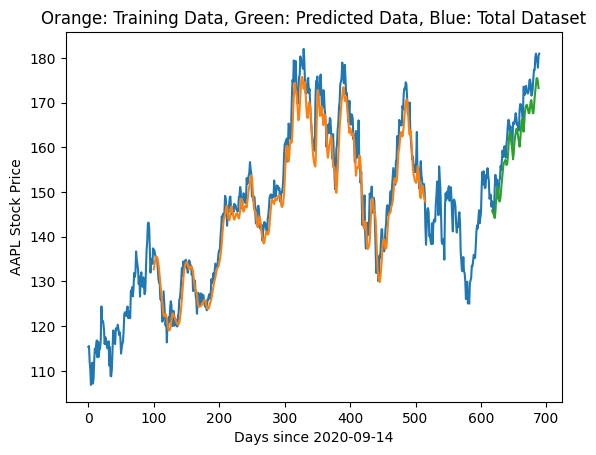

In [60]:
look_back=100
trainPredictPlot = np.empty_like(dataFrame)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_prediction)+look_back, :] = train_prediction

testPredictPlot = np.empty_like(dataFrame)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_prediction)+(look_back*2)+1:len(dataFrame)-1, :] = validation_prediction

plt.plot(scaler.inverse_transform(dataFrame))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel("Days since 2020-09-14")
plt.ylabel(stock + " Stock Price")
plt.title("Orange: Training Data, Green: Predicted Data, Blue: Total Dataset")
plt.show()

In [61]:
# Predicting the validation data
len(validation_data)    # 173
# Taking data from 100 days ago to current.
x_input = validation_data[73:].reshape(1,-1)
len(validation_data), x_input.shape

(173, (1, 100))

In [62]:
# Getting datapoints into a list.
list_input = list(x_input)
list_input = list_input[0].tolist()
list_input

[0.37741120127710537,
 0.37820939204469894,
 0.4127976586404152,
 0.45589996009046185,
 0.4747904749235068,
 0.4658773446853801,
 0.49381402155115084,
 0.520021285087136,
 0.4810429692696554,
 0.49820407077291473,
 0.5133696953571905,
 0.5850738326460023,
 0.6340295330584009,
 0.5971797259545029,
 0.6360250099773848,
 0.5997073300518823,
 0.5857389916189972,
 0.5876014367433817,
 0.625382466409472,
 0.6167353997605427,
 0.6450711720101108,
 0.6235200212850871,
 0.6080883331116138,
 0.5539443927098575,
 0.5596647598776108,
 0.5661833178129574,
 0.5303977650658509,
 0.5464946122123187,
 0.5397099906877745,
 0.5117733138220035,
 0.519755221497938,
 0.5878675003325795,
 0.6251164028202743,
 0.5954503126247173,
 0.6123453505387788,
 0.5820141013702278,
 0.5542104562990555,
 0.5804177198350406,
 0.6086204602900094,
 0.613941732073966,
 0.6519888253292536,
 0.6406811227883464,
 0.6726087534920846,
 0.6976187308766795,
 0.6783291206598379,
 0.6929626180657178,
 0.7105228149527738,
 0.684315551

In [63]:
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(list_input)>100):
        #print(temp_input)
        x_input=np.array(list_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = lstm_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        list_input.extend(yhat[0].tolist())
        list_input=list_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = lstm_model.predict(x_input, verbose=0)
        print(yhat[0])
        list_input.extend(yhat[0].tolist())
        print(len(list_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.89957666]
101
1 day input [0.37820939 0.41279766 0.45589996 0.47479047 0.46587734 0.49381402
 0.52002129 0.48104297 0.49820407 0.5133697  0.58507383 0.63402953
 0.59717973 0.63602501 0.59970733 0.58573899 0.58760144 0.62538247
 0.6167354  0.64507117 0.62352002 0.60808833 0.55394439 0.55966476
 0.56618332 0.53039777 0.54649461 0.53970999 0.51177331 0.51975522
 0.5878675  0.6251164  0.59545031 0.61234535 0.5820141  0.55421046
 0.58041772 0.60862046 0.61394173 0.65198883 0.64068112 0.67260875
 0.69761873 0.67832912 0.69296262 0.71052281 0.68431555 0.67593455
 0.71744047 0.73859252 0.7723826  0.78927764 0.78209392 0.75721697
 0.76918984 0.73420247 0.71783956 0.70852734 0.7811627  0.77650659
 0.77677265 0.79326859 0.80870028 0.79566316 0.77397898 0.77810297
 0.75735001 0.75721697 0.81907676 0.8359718  0.83477451 0.82080617
 0.80630571 0.78422243 0.88772117 0.88678994 0.86377544 0.88752162
 0.89011574 0.87441799 0.8677664  0.8677664  0.87601437 0.90740987
 0.90887322 0.89610217 0.86098177

In [64]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)
len(dataFrame)

690

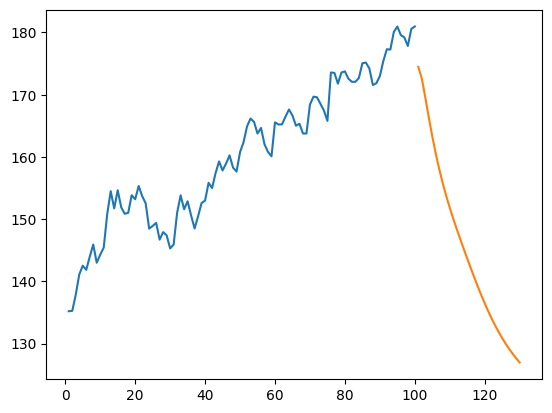

In [68]:
plt.plot(day_new,scaler.inverse_transform(dataFrame[590:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

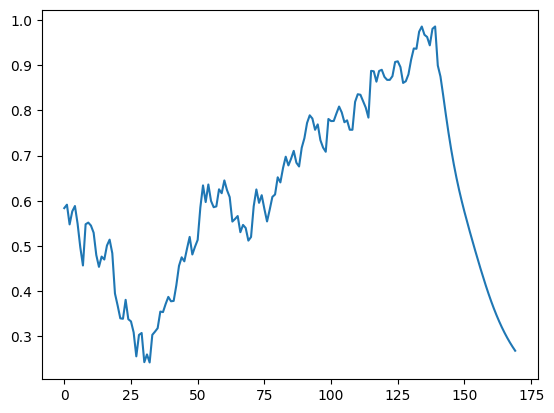

In [69]:
df = dataFrame.tolist()
df.extend(lst_output)
plt.plot(df[550:])

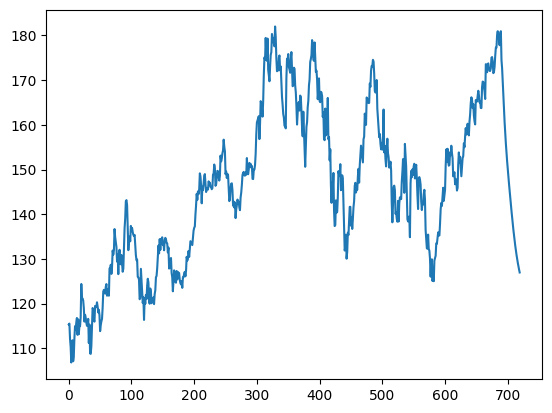

In [70]:
df = scaler.inverse_transform(df).tolist()
plt.plot(df)